In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)


C:\Users\isfun\AppData\Local\Temp\ipykernel_24396\376805655.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect = True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"{most_recent_date}")

2017-08-23


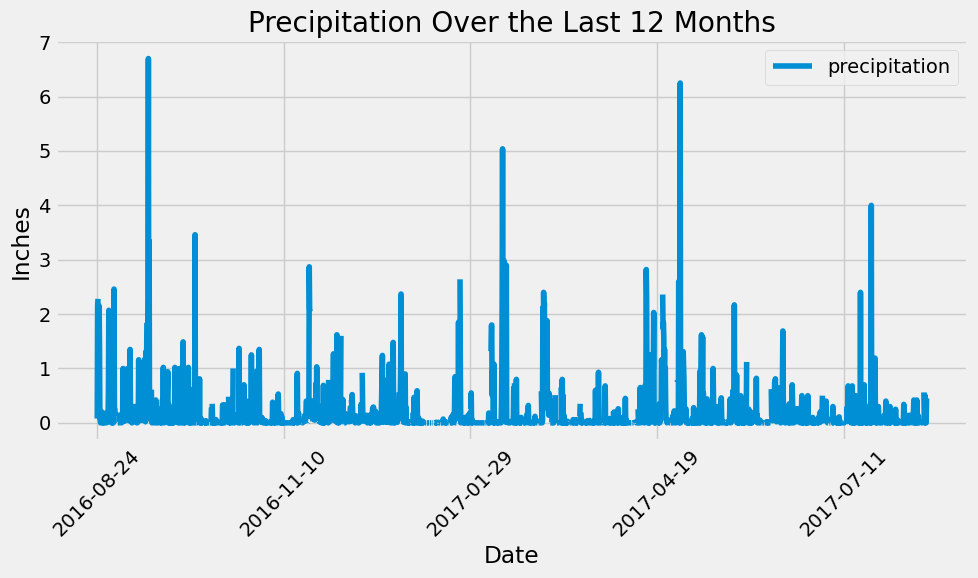

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Display the first few rows of the DataFrame
precipitation_df.head()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(
    x='date', 
    y='prcp', 
    figsize=(10, 6), 
    legend=True, 
    title='Precipitation Over the Last 12 Months'
)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.legend(['precipitation'], loc='upper right')
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['prcp'].describe()

precipitation_summary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Display the total number of stations
print(f"{total_stations}")

9


In [22]:
# Design a query to find the most active stations
# List the stations and their counts in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

for station, count in most_active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


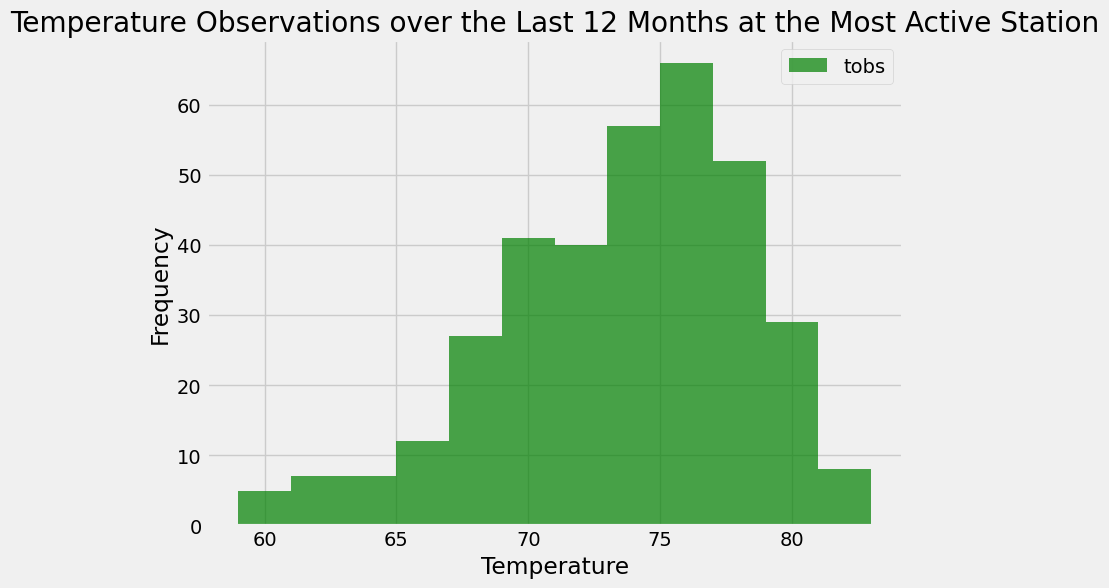

In [23]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    all()

temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='green', alpha=0.7, label='tobs')
plt.title('Temperature Observations over the Last 12 Months at the Most Active Station')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Close Session

In [24]:
# Close Session
session.close()